### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import datetime

In [2]:
df = pd.read_csv('data/Final_merged_dataset_clean.csv')

In [3]:
df.head(5)

id  home_team_api_id  away_team_api_id  crossing_h  finishing_h  \
0  1729             10260             10261        81.0         72.0   
1  1730              9825              8659        77.0         80.0   
2  1731              8472              8650        79.0         66.0   
3  1732              8654              8528        81.0         71.0   
4  1734              8668              8655        74.0         80.0   

   heading_accuracy_h  short_passing_h  volleys_h  dribbling_h  curve_h  ...  \
0                81.0             81.0       79.0         79.0     79.0  ...   
1                90.0             88.0       79.0         79.0     80.0  ...   
2                78.0             82.0       69.0         80.0     78.0  ...   
3                77.0             87.0       69.0         81.0     80.0  ...   
4                74.0             83.0       77.0         80.0     78.0  ...   

   defenceAggression_h  defenceTeamWidth_h  buildUpPlaySpeed_a  \
0            48.000000           54.833333           58.166667   
1            46.500000           50.500000           57.500000   
2            52.166667           51.833333           57.666667   
3            42.833333           40.166667           47.166667   
4            57.500000           56.333333           52.500000   

   buildUpPlayPassing_a  chanceCreationPassing_a  chanceCreationCrossing_a  \
0             55.333333                53.500000                 57.333333   
1             51.500000                53.000000                 56.000000   
2             44.333333                41.333333                 47.833333   
3             50.666667                52.666667                 55.500000   
4             63.833333                57.000000                 56.000000   

   chanceCreationShooting_a  defencePressure_a  defenceAggression_a  \
0                 49.833333          46.666667            48.333333   
1                 54.666667          43.000000            45.666667   
2                 57.333333          51.000000            52.500000   
3                 45.500000          50.000000            54.000000   
4                 42.000000          45.666667            55.000000   

   defenceTeamWidth_a  
0           48.333333  
1           54.833333  
2           56.000000  
3           46.000000  
4           46.666667  

[5 rows x 96 columns]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['match_winner', 'id', 'home_team_api_id', 'away_team_api_id', 'fouls_h', 'fouls_a']), 
                                                    df.match_winner, test_size=0.3, 
                                                    random_state=47)

In [5]:
X_train.shape, X_test.shape

((9307, 90), (3990, 90))

In [6]:
y_train.shape, y_test.shape

((9307,), (3990,))

In [7]:
train_mean = y_train.mean()
train_mean

1.8189534758783712

Draw most likely outcome, though this could be influence by even distribution of wins and losses for home teams

In [8]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1.81895348]])

In [9]:
X_defaults_median = X_train.median()
X_train = X_train.fillna(X_defaults_median)
X_test = X_test.fillna(X_defaults_median)

In [10]:
scaler = StandardScaler()

In [11]:
scaler.fit(X_train)

StandardScaler()

In [12]:
X_tr = scaler.transform(X_train)
X_te = scaler.transform(X_test)

# Logistic Regression

In [13]:
log_reg = LogisticRegression(max_iter = 200)

In [14]:
log_reg.fit(X_tr, y_train)

LogisticRegression(max_iter=200)

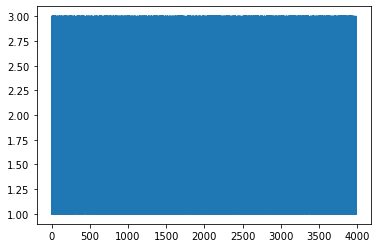

In [15]:
plt.plot(log_reg.predict(X_te))

# KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier()

In [17]:
knn.fit(X_tr, y_train)

KNeighborsClassifier()

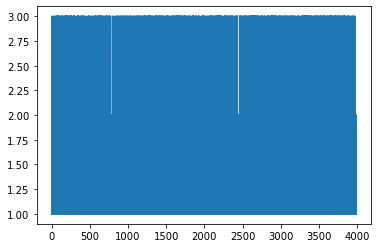

In [18]:
plt.plot(knn.predict(X_te))

# Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators=10)

In [36]:
rf.fit(X_tr, y_train)

RandomForestClassifier(n_estimators=10)

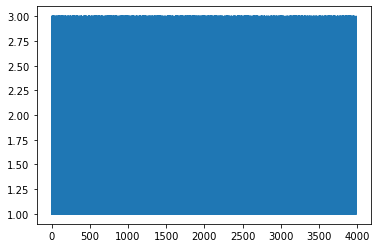

In [37]:
plt.plot(rf.predict(X_te))

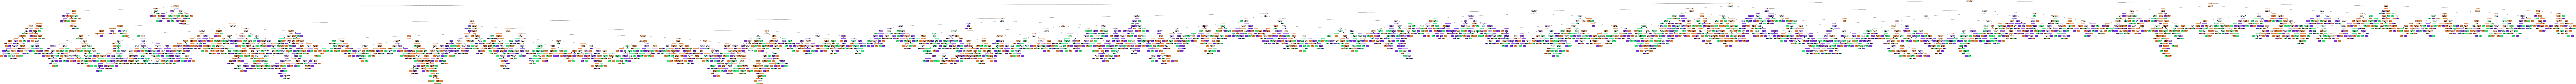

In [39]:
from sklearn.ensemble import RandomForestClassifier

estimator = rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns.values,
                #class_names = X_train.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

# Ridge Classifier

In [40]:
rc = RidgeClassifier()

In [41]:
rc.fit(X_tr, y_train)

RidgeClassifier()

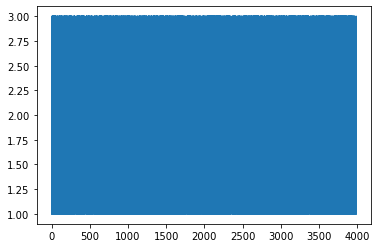

In [42]:
plt.plot(rc.predict(X_te))

# Support Vectors

In [43]:
svc = SVC()

In [44]:
svc.fit(X_tr, y_train)

SVC()

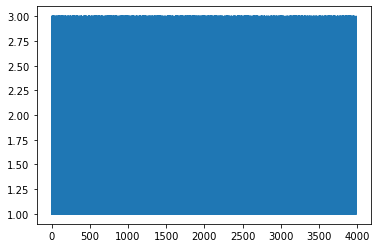

In [45]:
plt.plot(rf.predict(X_te))

# Initial Model Metrics

In [46]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score), 
           'recall' : make_scorer(recall_score)}

In [47]:
models = [log_reg, knn, rf, rc, svc]

In [48]:
kfold = KFold(n_splits=10)

In [49]:
for i, model in enumerate(models):
    cv_results = cross_validate(model, X_te, y_test, cv=kfold, scoring=scoring, n_jobs=-1)
    print(model, cv_results['test_accuracy'], cv_results['test_precision'], cv_results['test_recall'])

LogisticRegression(max_iter=200) [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
KNeighborsClassifier() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
RandomForestClassifier(n_estimators=10) [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
RidgeClassifier() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
SVC() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]


In [50]:
for i, model in enumerate(models):
    print(model, model.score(X_te, y_test))

LogisticRegression(max_iter=200) 0.47468671679197993
KNeighborsClassifier() 0.4421052631578947
RandomForestClassifier(n_estimators=10) 0.43759398496240604
RidgeClassifier() 0.47468671679197993
SVC() 0.48621553884711777


In [51]:
for i, model in enumerate(models):
    print(model, model.get_params())

LogisticRegression(max_iter=200) {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
KNeighborsClassifier() {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
RandomForestClassifier(n_estimators=10) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
RidgeClassifier() {'alpha': 1.0, 'class_weight': None, 'co

In [52]:
for i, model in enumerate(models):
    cv_results = cross_val_score(model, X_tr, y_train, scoring='accuracy')
    print(model, cv_results.mean(), cv_results.std())

LogisticRegression(max_iter=200) 0.4859787451279615 0.0034349075394915656
KNeighborsClassifier() 0.4504134559166012 0.009197858101198863
RandomForestClassifier(n_estimators=10) 0.45180911132517715 0.00712944414828664
RidgeClassifier() 0.48909431019784816 0.0029444487041901776
SVC() 0.5024175353560073 0.0031375981204166173


# Feature Selection

In [53]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [54]:
skb = SelectKBest(k=20)

In [55]:
for i, model in enumerate(models):
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    print(model, cv_results['test_accuracy'], cv_results['test_precision'], cv_results['test_recall'])

LogisticRegression(max_iter=200) [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
KNeighborsClassifier() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
RandomForestClassifier(n_estimators=10) [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
RidgeClassifier() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]
SVC() [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan] [nan nan nan nan nan nan nan nan nan nan]


In [56]:
skb.fit(X_train, y_train)

SelectKBest(k=20)

In [57]:
skb.transform(X_train).shape

(9307, 20)

In [58]:
kbest_score = {}
for i, score in enumerate(skb.scores_):
    #print(X_train.columns.values[i], score)
    kbest_score[X_train.columns.values[i]] = score

In [59]:
sorted_values = sorted(kbest_score.values()) # Sort the values
kbest_sorted = {}
for i in sorted_values:
    for k in kbest_score.keys():
        if kbest_score[k] == i:
            kbest_sorted[k] = kbest_score[k]
            break
print(kbest_sorted)

{'free_kick_accuracy_a': 0.003946553201582885, 'finishing_h': 0.015565629742610313, 'long_passing_h': 0.040844261830737076, 'curve_a': 0.061915289489999976, 'home_defenders': 0.0660321043947787, 'crossing_h': 0.07886987650736431, 'away_defenders': 0.0895365022578001, 'chanceCreationPassing_a': 0.25969027849397364, 'shot_power_a': 0.29016225114711786, 'crossing_a': 0.32911133897976785, 'stamina_a': 0.34460426092515006, 'gk_reflexes_h': 0.4539603102463932, 'sprint_speed_h': 0.4559009584110194, 'gk_diving_h': 0.5005759732617799, 'gk_positioning_a': 0.5170637261695158, 'balance_h': 0.5197769716014378, 'acceleration_h': 0.5227393364890152, 'gk_handling_a': 0.5301290481221081, 'free_kick_accuracy_h': 0.5553630122227696, 'dribbling_h': 0.6315776766146874, 'gk_diving_a': 0.70553812995803, 'gk_handling_h': 0.7703392166103782, 'gk_reflexes_a': 0.7718228303405128, 'strength_h': 0.7810897810573842, 'sprint_speed_a': 0.8086125323198872, 'dribbling_a': 0.8093665614809129, 'gk_positioning_h': 0.85904

In [60]:
features = list(kbest_sorted.keys())[:20]

In [61]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df[features], 
                                                    df.match_winner, test_size=0.3)

In [62]:
train_mean2 = y2_train.mean()
train_mean2

1.8204577199957022

Draw most likely outcome, though this could be influence by even distribution of wins and losses for home teams

In [63]:
dumb_reg2 = DummyRegressor(strategy='mean')
dumb_reg2.fit(X2_train, y2_train)
dumb_reg2.constant_

array([[1.82045772]])

In [64]:
X2_defaults_median = X2_train.median()
X2_train = X2_train.fillna(X2_defaults_median)
X2_test = X2_test.fillna(X2_defaults_median)

In [65]:
scaler2 = StandardScaler()

In [66]:
scaler2.fit(X2_train)

StandardScaler()

In [67]:
X2_tr = scaler2.transform(X2_train)
X2_te = scaler2.transform(X2_test)

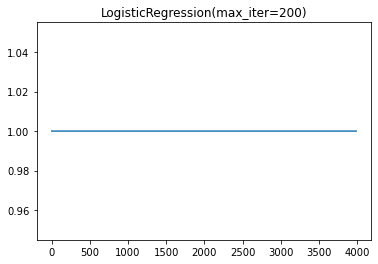

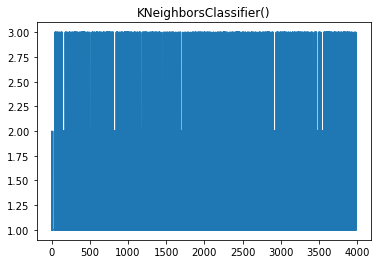

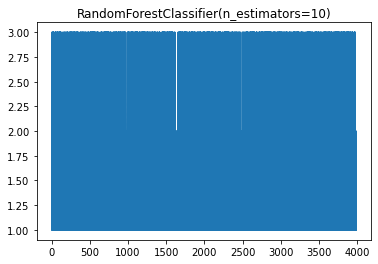

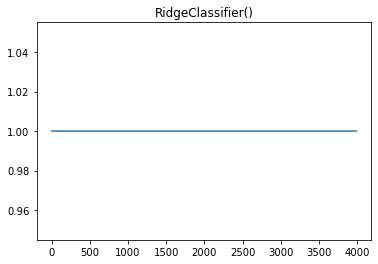

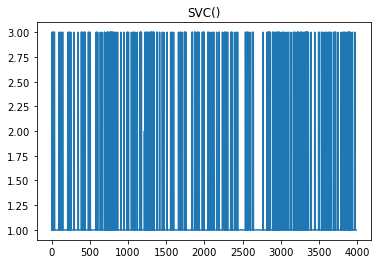

In [68]:
for i, model in enumerate(models):
    model.fit(X2_tr, y2_train)
    plt.figure()
    plt.plot(model.predict(X2_te))
    plt.title(model)

# Hyperparameter Tuning

In [69]:
param_search = {}
param_search[0] = {}
param_search[1] = {'n_neighbors' : [1, 5, 10, 20, 50, 100, 200], 'weights' : ['uniform', 'distance'], 
                       'leaf_size' : [5, 10, 20, 30, 50], 'p' : [1,2] ,'n_jobs' :[-1]}
param_search[2] = {'n_estimators' : [20, 50, 100, 200], 'n_jobs' : [-1]}
param_search[3] = {}
tuned_results = []
tuned_best_score = []
tuned_best_estimator = []
print(param_search)

{0: {}, 1: {'n_neighbors': [1, 5, 10, 20, 50, 100, 200], 'weights': ['uniform', 'distance'], 'leaf_size': [5, 10, 20, 30, 50], 'p': [1, 2], 'n_jobs': [-1]}, 2: {'n_estimators': [20, 50, 100, 200], 'n_jobs': [-1]}, 3: {}}


In [70]:
#for i, model in enumerate(models):
    #if name != 'LR':
#    gsearch = GridSearchCV(estimator=model, param_grid = param_search[i], scoring = 'accuracy')
    #if name != 'RFR':
#    gsearch.fit(X_tr, y_train)
    #else :
       # gsearch.fit(X_tr, y_train.values.ravel())
#    best_score = gsearch.best_score_
#    best_model = gsearch.best_estimator_
#    tuned_results.append(gsearch)
#    tuned_best_score.append(best_score)
#    tuned_best_estimator.append(best_model)
#    print(best_model, best_score)

In [71]:
#for model in tuned_best_estimator:
#    model.fit(X_tr, y_train)
#    plt.figure()
#    plt.plot(model.predict(X_te))
#    print(model)
#plt.show()

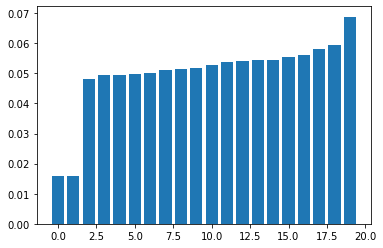

In [72]:
importance = rf.feature_importances_
importance.sort()
plt.bar([x for x in range(len(importance))], importance)
plt.show()

(array([6155.,    0.,    0.,    0.,    0., 3373.,    0.,    0.,    0.,
        3769.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

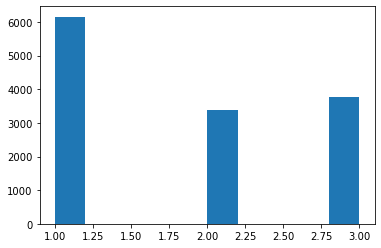

In [73]:
plt.hist(df['match_winner'])

In [74]:
from sklearn.metrics import confusion_matrix
pl_list = []
for i, model in enumerate(models):
    y2_pred = model.predict(X2_te)
    pl_list.append(confusion_matrix(y2_test,y2_pred))

In [75]:
class_names=['3', '2', '1'] # name  of classes

In [76]:
def plot_confusion_matrix(cm, classes ,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[1844    0    0]
 [1017    0    0]
 [1129    0    0]]
Confusion matrix, without normalization
[[1332  315  197]
 [ 685  190  142]
 [ 744  208  177]]
Confusion matrix, without normalization
[[1295  250  299]
 [ 686  150  181]
 [ 646  202  281]]
Confusion matrix, without normalization
[[1844    0    0]
 [1017    0    0]
 [1129    0    0]]
Confusion matrix, without normalization
[[1769    2   73]
 [ 964    1   52]
 [1031    2   96]]


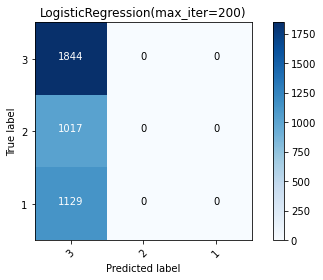

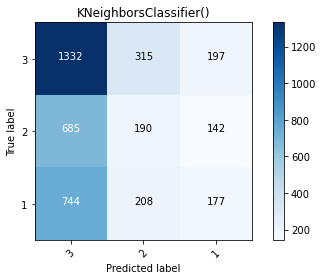

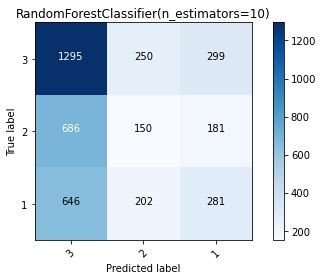

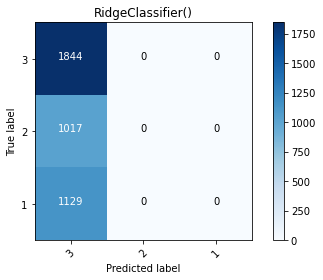

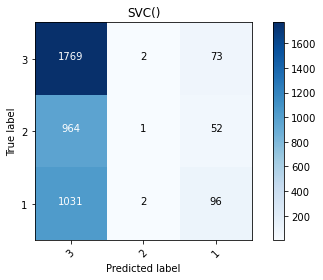

In [77]:
for i, model in enumerate(models):
    plot_confusion_matrix(pl_list[i], class_names, title=model)

In [78]:
features

['free_kick_accuracy_a',
 'finishing_h',
 'long_passing_h',
 'curve_a',
 'home_defenders',
 'crossing_h',
 'away_defenders',
 'chanceCreationPassing_a',
 'shot_power_a',
 'crossing_a',
 'stamina_a',
 'gk_reflexes_h',
 'sprint_speed_h',
 'gk_diving_h',
 'gk_positioning_a',
 'balance_h',
 'acceleration_h',
 'gk_handling_a',
 'free_kick_accuracy_h',
 'dribbling_h']

free_kick_accuracy_a
finishing_h
long_passing_h
curve_a
home_defenders
crossing_h
away_defenders
chanceCreationPassing_a
shot_power_a
crossing_a
stamina_a
gk_reflexes_h
sprint_speed_h
gk_diving_h
gk_positioning_a
balance_h
acceleration_h
gk_handling_a
free_kick_accuracy_h
dribbling_h


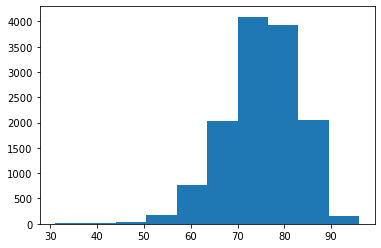

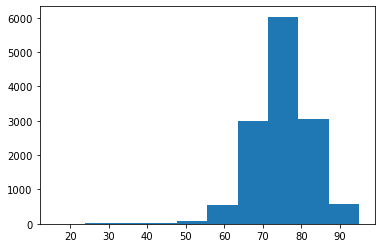

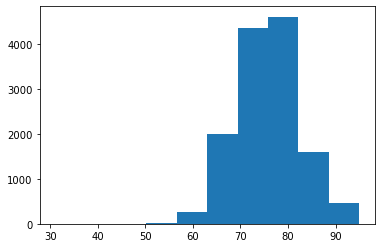

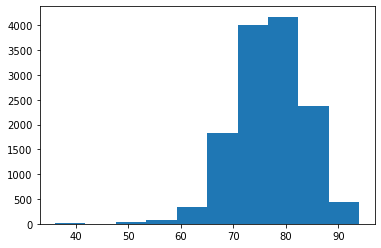

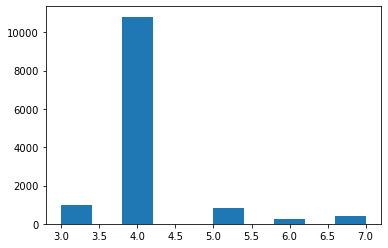

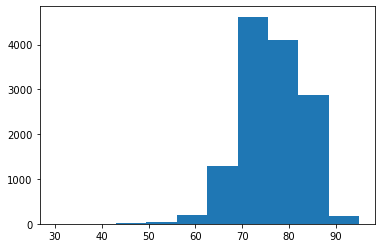

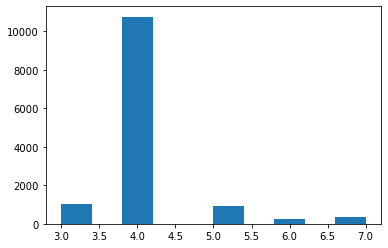

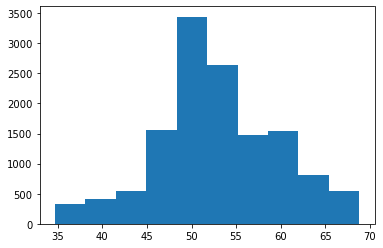

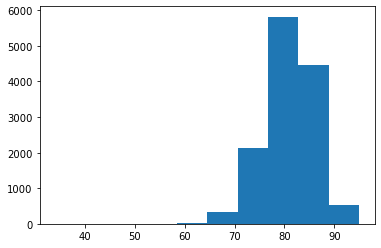

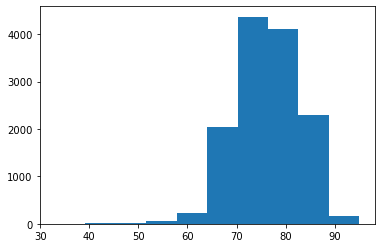

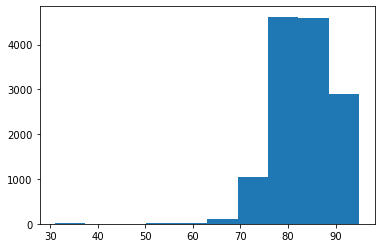

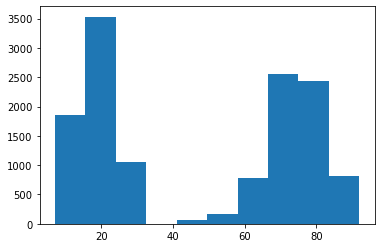

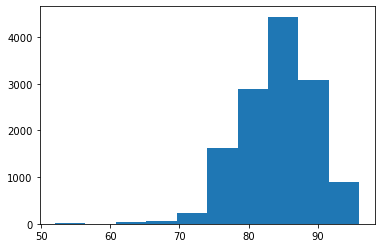

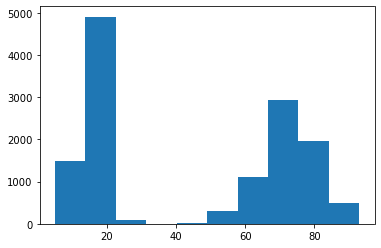

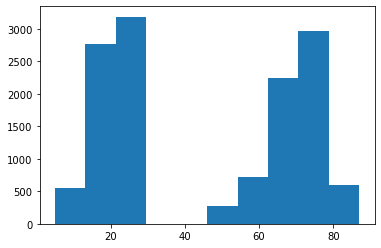

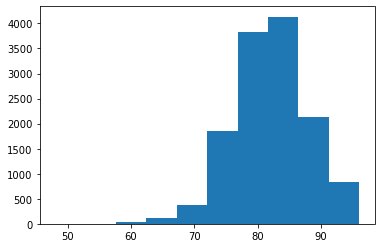

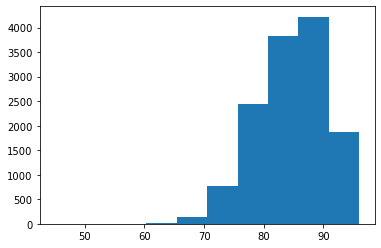

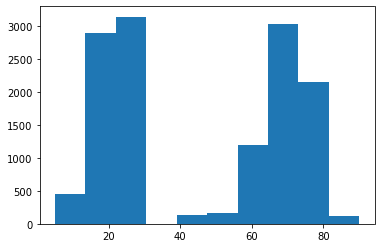

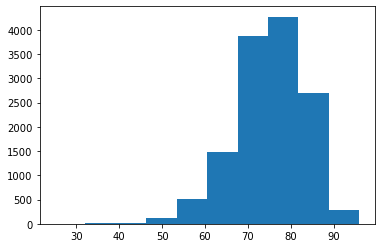

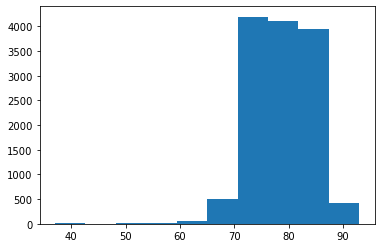

In [79]:
for i in features:
    print(i)
    plt.figure()
    plt.hist(df[i])

In [80]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(),
    LogisticRegression(max_iter=200),
)

In [81]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest()),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [82]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [83]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [84]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=200))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [85]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

{'selectkbest__k': 44}


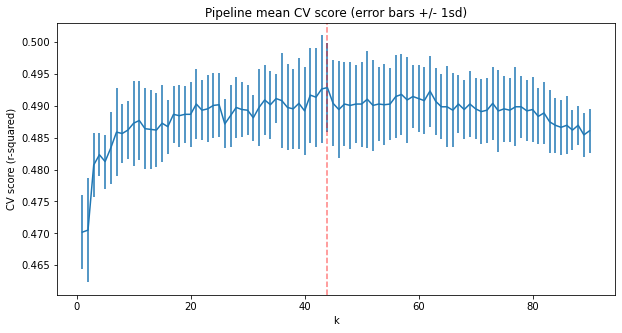

In [86]:
print(lr_grid_cv.best_params_)
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [87]:
pipe2 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(k=44),
    LogisticRegression(max_iter=200),
)

In [88]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=44)),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [89]:
y_pred = pipe2.predict(X_test)

In [90]:
cf = confusion_matrix(y_test,y_pred)

Confusion matrix, without normalization
[[1508   12  299]
 [ 820    9  224]
 [ 737    5  376]]


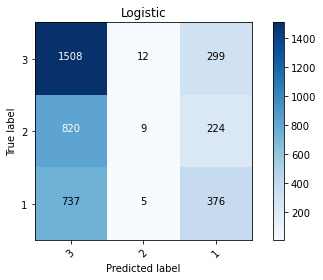

In [91]:
plot_confusion_matrix(cf, class_names, title='Logistic')

In [95]:
pipe3 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(k=44),
    KNeighborsClassifier(),
)

In [96]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=44)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [97]:
y_pred2 = pipe3.predict(X_test)

In [98]:
cf2 = confusion_matrix(y_test,y_pred2)

Confusion matrix, without normalization
[[1274  319  226]
 [ 643  219  191]
 [ 621  241  256]]


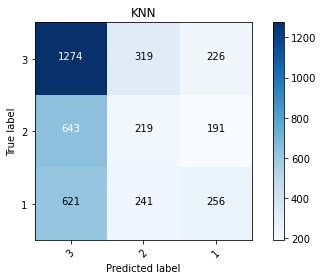

In [99]:
plot_confusion_matrix(cf2, class_names, title='KNN')

In [101]:
pipe4 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(k=44),
    RandomForestClassifier(),
)

In [102]:
pipe4.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest', SelectKBest(k=44)),
                ('randomforestclassifier', RandomForestClassifier())])

In [103]:
y_pred4 = pipe4.predict(X_test)

In [104]:
cf4 = confusion_matrix(y_test,y_pred4)

Confusion matrix, without normalization
[[1450  123  246]
 [ 744   78  231]
 [ 657   99  362]]


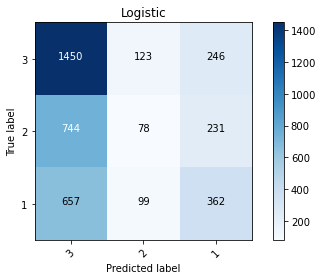

In [105]:
plot_confusion_matrix(cf4, class_names, title='Logistic')

<Figure size 1800x1200 with 0 Axes>

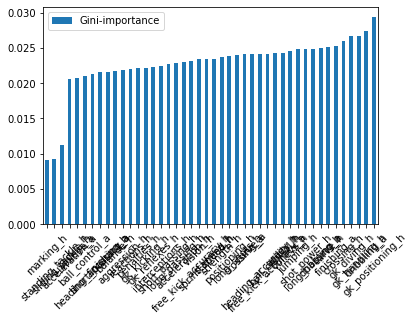

In [133]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns, pipe4.steps[3][1].feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
plt.figure(dpi=300)
plt.tight_layout()
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)
plt.savefig('featureimportances.jpg', dpi=200)


In [138]:
importances.sort_values(by='Gini-importance', ascending=False)

Gini-importance
gk_positioning_h             0.029381
dribbling_a                  0.027401
gk_handling_h                0.026726
gk_diving_h                  0.026701
crossing_h                   0.026007
finishing_a                  0.025314
curve_h                      0.025185
dribbling_h                  0.024917
long_passing_a               0.024871
shot_power_h                 0.024837
jumping_h                    0.024782
volleys_h                    0.024539
agility_h                    0.024263
ball_control_h               0.024221
free_kick_accuracy_a         0.024144
heading_accuracy_h           0.024120
curve_a                      0.024104
crossing_a                   0.024079
long_shots_h                 0.024021
positioning_h                0.023849
strength_h                   0.023671
stamina_h                    0.023394
sprint_speed_h               0.023380
vision_h                     0.023373
free_kick_accuracy_h         0.023117
acceleration_h               0.023021
long_passing_h               0.022866
short_passing_h              0.022747
interceptions_h              0.022485
gk_reflexes_h                0.022315
gk_kicking_h                 0.022188
penalties_h                  0.022161
reactions_h                  0.022025
aggression_h                 0.021907
balance_h                    0.021673
finishing_h                  0.021636
short_passing_a              0.021581
heading_accuracy_a           0.021253
ball_control_a               0.020957
volleys_a                    0.020685
acceleration_a               0.020642
sliding_tackle_h             0.011226
standing_tackle_h            0.009189
marking_h                    0.009048

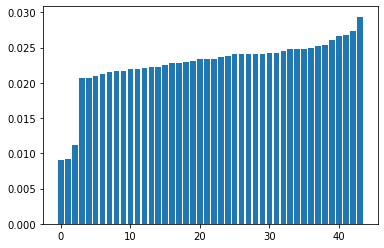

In [113]:
importance = pipe4.steps[3][1].feature_importances_
importance.sort()
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [114]:
kbest_score = {}
for i, score in enumerate(skb.scores_):
    #print(X_train.columns.values[i], score)
    kbest_score[X_train.columns.values[i]] = score

In [115]:
sorted_values = sorted(kbest_score.values(), reverse=True) # Sort the values
kbest_sorted = {}
for i in sorted_values:
    for k in kbest_score.keys():
        if kbest_score[k] == i:
            kbest_sorted[k] = kbest_score[k]
            break
print(kbest_sorted)

{'buildUpPlayPassing_h': 81.90724385968889, 'defencePressure_a': 77.68463052053018, 'buildUpPlayPassing_a': 76.62631898110682, 'defencePressure_h': 68.15745446168533, 'chanceCreationShooting_h': 30.72459740662652, 'interceptions_a': 28.603195266336108, 'chanceCreationShooting_a': 28.16873000380979, 'possession_h': 15.1942238973895, 'vision_h': 14.890572297013604, 'interceptions_h': 12.99113488768439, 'away_strikers': 11.235765519864557, 'defenceAggression_a': 11.136874549094873, 'defenceTeamWidth_a': 10.341126325468851, 'heading_accuracy_a': 10.294047971900262, 'defenceAggression_h': 9.895751764710184, 'defenceTeamWidth_h': 9.402922669093543, 'positioning_a': 8.885799640702036, 'volleys_h': 8.234677642372453, 'standing_tackle_h': 8.216783298657624, 'reactions_a': 7.460395019203794, 'aggression_a': 7.396953956705028, 'standing_tackle_a': 7.123940006119333, 'short_passing_a': 6.808360913607796, 'vision_a': 6.735743156822005, 'aggression_h': 6.029485974237208, 'away_midfielders': 5.764043

In [139]:
kbest_sorted

{'buildUpPlayPassing_h': 81.90724385968889,
 'defencePressure_a': 77.68463052053018,
 'buildUpPlayPassing_a': 76.62631898110682,
 'defencePressure_h': 68.15745446168533,
 'chanceCreationShooting_h': 30.72459740662652,
 'interceptions_a': 28.603195266336108,
 'chanceCreationShooting_a': 28.16873000380979,
 'possession_h': 15.1942238973895,
 'vision_h': 14.890572297013604,
 'interceptions_h': 12.99113488768439,
 'away_strikers': 11.235765519864557,
 'defenceAggression_a': 11.136874549094873,
 'defenceTeamWidth_a': 10.341126325468851,
 'heading_accuracy_a': 10.294047971900262,
 'defenceAggression_h': 9.895751764710184,
 'defenceTeamWidth_h': 9.402922669093543,
 'positioning_a': 8.885799640702036,
 'volleys_h': 8.234677642372453,
 'standing_tackle_h': 8.216783298657624,
 'reactions_a': 7.460395019203794,
 'aggression_a': 7.396953956705028,
 'standing_tackle_a': 7.123940006119333,
 'short_passing_a': 6.808360913607796,
 'vision_a': 6.735743156822005,
 'aggression_h': 6.029485974237208,
 'aw

In [142]:
kbest_sorted_df = pd.DataFrame.from_dict(kbest_sorted, orient='index')

In [144]:
kbest_sorted_df.head(20)

0
buildUpPlayPassing_h      81.907244
defencePressure_a         77.684631
buildUpPlayPassing_a      76.626319
defencePressure_h         68.157454
chanceCreationShooting_h  30.724597
interceptions_a           28.603195
chanceCreationShooting_a  28.168730
possession_h              15.194224
vision_h                  14.890572
interceptions_h           12.991135
away_strikers             11.235766
defenceAggression_a       11.136875
defenceTeamWidth_a        10.341126
heading_accuracy_a        10.294048
defenceAggression_h        9.895752
defenceTeamWidth_h         9.402923
positioning_a              8.885800
volleys_h                  8.234678
standing_tackle_h          8.216783
reactions_a                7.460395

In [145]:
importances.sort_values(by='Gini-importance', ascending=False).head(20)

Gini-importance
gk_positioning_h             0.029381
dribbling_a                  0.027401
gk_handling_h                0.026726
gk_diving_h                  0.026701
crossing_h                   0.026007
finishing_a                  0.025314
curve_h                      0.025185
dribbling_h                  0.024917
long_passing_a               0.024871
shot_power_h                 0.024837
jumping_h                    0.024782
volleys_h                    0.024539
agility_h                    0.024263
ball_control_h               0.024221
free_kick_accuracy_a         0.024144
heading_accuracy_h           0.024120
curve_a                      0.024104
crossing_a                   0.024079
long_shots_h                 0.024021
positioning_h                0.023849

In [ ]:
pl_list.append(confusion_matrix(y2_test,y2_pred))

In [ ]:
models